In [1]:
import librosa
import numpy as np

AUDIO_PATH = "../audio/downloaded/test.wav"

audio, sr = librosa.load(AUDIO_PATH, sr=16000)

print("Audio loaded")
print("Sample rate:", sr)
print("Audio length (seconds):", len(audio) / sr)

C:\Users\abhyu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Audio loaded
Sample rate: 16000
Audio length (seconds): 3361.392


In [2]:
from faster_whisper import WhisperModel

MODEL_PATH = r"C:\whisper_models\faster-whisper-small"

model = WhisperModel(
    MODEL_PATH,
    device="cpu",
    compute_type="int8"
)

segments, info = model.transcribe(
    AUDIO_PATH,
    word_timestamps=True
)

segments = list(segments)

In [3]:
words = []

for segment in segments:
    if segment.words is None:
        continue
    for w in segment.words:
        words.append({
            "word": w.word,
            "start": w.start,
            "end": w.end
        })

print("Total words:", len(words))
print(words[:5])

Total words: 5934
[{'word': ' Hi', 'start': np.float64(16.039999999999996), 'end': np.float64(16.919999999999998)}, {'word': ' everybody,', 'start': np.float64(16.919999999999998), 'end': np.float64(17.8)}, {'word': ' this', 'start': np.float64(18.1), 'end': np.float64(18.26)}, {'word': ' is', 'start': np.float64(18.26), 'end': np.float64(18.42)}, {'word': ' Pam', 'start': np.float64(18.42), 'end': np.float64(18.7)}]


In [4]:
def get_audio_segment(audio, sr, start, end):
    start_sample = int(start * sr)
    end_sample = int(end * sr)
    return audio[start_sample:end_sample]

In [5]:
test_word = words[0]
segment_audio = get_audio_segment(
    audio,
    sr,
    test_word["start"],
    test_word["end"]
)

print("Segment length (samples):", len(segment_audio))
print("Segment length (seconds):", len(segment_audio) / sr)

Segment length (samples): 14080
Segment length (seconds): 0.88


In [6]:
def extract_features(segment_audio, sr):
    features = {}

    # Duration
    features["duration"] = len(segment_audio) / sr

    # RMS Energy
    rms = librosa.feature.rms(y=segment_audio)
    features["rms_mean"] = np.mean(rms)

    # Zero Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(segment_audio)
    features["zcr_mean"] = np.mean(zcr)

    # MFCCs
    mfcc = librosa.feature.mfcc(y=segment_audio, sr=sr, n_mfcc=13)
    for i in range(13):
        features[f"mfcc_{i}_mean"] = np.mean(mfcc[i])

    return features

In [7]:
features = extract_features(segment_audio, sr)
print(features)

{'duration': 0.88, 'rms_mean': np.float32(0.035657298), 'zcr_mean': np.float64(0.04823521205357143), 'mfcc_0_mean': np.float32(-285.56296), 'mfcc_1_mean': np.float32(154.94566), 'mfcc_2_mean': np.float32(-29.796968), 'mfcc_3_mean': np.float32(46.030666), 'mfcc_4_mean': np.float32(-5.501808), 'mfcc_5_mean': np.float32(16.915274), 'mfcc_6_mean': np.float32(0.9244877), 'mfcc_7_mean': np.float32(10.547995), 'mfcc_8_mean': np.float32(-9.193559), 'mfcc_9_mean': np.float32(-3.0895765), 'mfcc_10_mean': np.float32(-12.643684), 'mfcc_11_mean': np.float32(-1.0525115), 'mfcc_12_mean': np.float32(1.2653874)}


In [8]:
word_features = []

for w in words:
    segment_audio = get_audio_segment(
        audio, sr, w["start"], w["end"]
    )

    if len(segment_audio) < 200:  # skip very tiny segments
        continue

    feats = extract_features(segment_audio, sr)

    word_features.append({
        "word": w["word"],
        "start": w["start"],
        "end": w["end"],
        **feats
    })

print("Extracted features for", len(word_features), "words")

C:\Users\abhyu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1920
  warnings.warn(
C:\Users\abhyu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1600
  warnings.warn(
C:\Users\abhyu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1280
  warnings.warn(
C:\Users\abhyu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=19

Extracted features for 5932 words


In [10]:
# --------------------------------------------
# SAVE WORD-LEVEL FEATURES TO CSV
# --------------------------------------------
import pandas as pd
features_df = pd.DataFrame(word_features)

OUTPUT_PATH = "../output/word_level_features_test.csv"
features_df.to_csv(OUTPUT_PATH, index=False)

print(f"\nSaved word-level features to: {OUTPUT_PATH}")
print("Columns:", list(features_df.columns))
print("Total rows:", len(features_df))


Saved word-level features to: ../output/word_level_features_test.csv
Columns: ['word', 'start', 'end', 'duration', 'rms_mean', 'zcr_mean', 'mfcc_0_mean', 'mfcc_1_mean', 'mfcc_2_mean', 'mfcc_3_mean', 'mfcc_4_mean', 'mfcc_5_mean', 'mfcc_6_mean', 'mfcc_7_mean', 'mfcc_8_mean', 'mfcc_9_mean', 'mfcc_10_mean', 'mfcc_11_mean', 'mfcc_12_mean']
Total rows: 5932


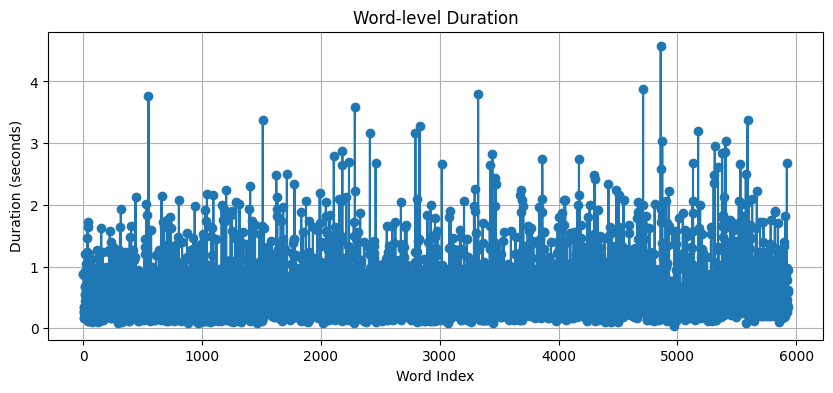

In [ ]:
# --------------------------------------------
# VISUALIZE WORD DURATIONS
# --------------------------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(features_df["duration"].values, marker="o")
plt.title("Word-level Duration")
plt.xlabel("Word Index")
plt.ylabel("Duration (seconds)")
plt.grid(True)
plt.show()

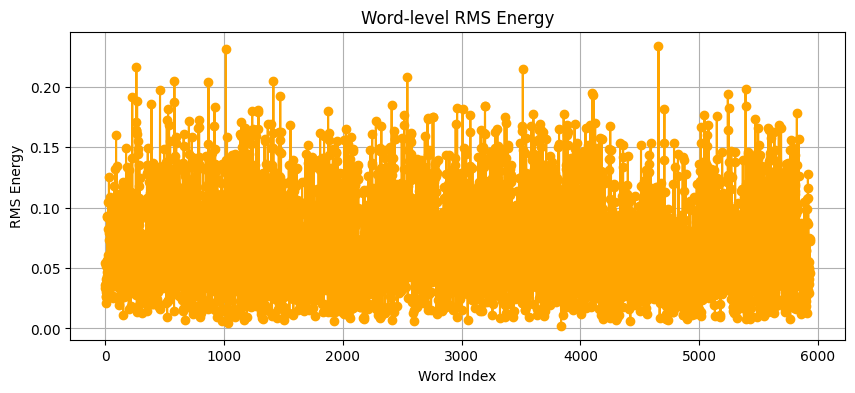

In [13]:
# --------------------------------------------
# VISUALIZE RMS ENERGY
# --------------------------------------------

plt.figure(figsize=(10, 4))
plt.plot(features_df["rms_mean"].values, marker="o", color="orange")
plt.title("Word-level RMS Energy")
plt.xlabel("Word Index")
plt.ylabel("RMS Energy")
plt.grid(True)
plt.show()

In [14]:
import pandas as pd

df = pd.read_csv("../output/word_level_features_labeled.csv")
print(df["label"].value_counts())

label
-1    4865
 0    1047
 1      15
 2       5
Name: count, dtype: int64
